# Variational Monte Carlo

Using the variational principle

$$ E_0 \leq \, < \Psi_T | \hat{H} | \Psi_T > $$

we can choose any wavefunction for a known Hamiltonian of a system.

The goal of the Metropolis random walk is to vary the parameters of the wavefunction $\Psi_T$ to minimize the ground energy, since the actual ground energy will always be lower. We can calculate the expectation value of our trial wavefunction

$$ E_v = \frac{\hat{H} \Psi_T}{\Psi_T} $$

A simple system is the hydrogen atom, which has a one-dimensional Hamiltonian

$$ \hat{H} = -\frac{1}{2} \nabla^2 - \frac{Z}{r} $$

0.95405


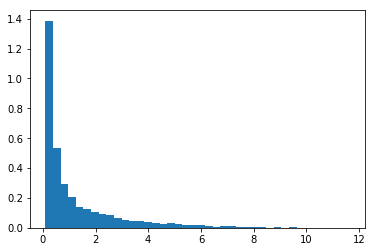

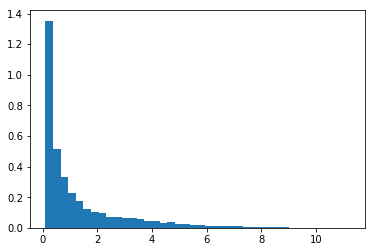

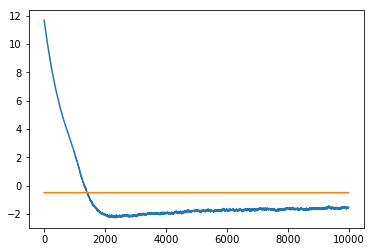

In [165]:
# TODO: Calculate acceptance rate

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class VMC:
    """
    Parameters
    ------------
    wavefunction (function): the trial wavefunction.
    hamiltonian (function): the hamiltonian of the trial wavefunction.
    n_parameters (int): the number of parameters the wavefunction requires.
    n_steps (int): the number of steps each walker will take in total.
    n_walkers (int): the number of walkers for each parameter.
    step_size (float): the maximum step size for each step.
    proposal_distribution (function): the sampling distribution for the Metropolis random walk.
    kwargs: key-value pairs corresponding to arguments in the proposal distribution.
    """
    def __init__(
            self,
            wavefunction,
            hamiltonian,
            n_parameters,
            n_steps=20,
            n_walkers=100,
            step_size=0.1,
            proposal_distribution=np.random.normal,
            **kwargs
    ):
        self.Psi = wavefunction
        self.H = hamiltonian
        self.n_params = n_parameters
        
        self.n_steps = n_steps
        self.n_walkers = n_walkers
        self.delta = step_size
        
        self.proposal = proposal_distribution
        self.kwargs = kwargs

        # Initalize random configuration of parameters
        self.current = np.ones(shape=[self.n_params, self.n_walkers]) * 5
        
        # Initialize expectation values
        self.E = []
        
        # Initialize acceptance rate
        self.accept = {'n_steps': 0, 'n_accepted': 0}

    def eval_proposal(self, current, proposal):
        """Evaluates the probability of a proposed move being accepted.
        """
        ratio = np.abs(self.Psi(proposal))**2 / np.abs(self.Psi(current))**2
        probability = np.min([np.ones(ratio.shape), ratio], axis=0)
        random = np.random.uniform(low=0, high=1, size=self.current.shape)
        return random < probability

    def run(self, plot=False, verbose=False):
        """Runs the entire simulation.
        """
        for step in range(self.n_steps):
            self.update()
            if verbose:
                print("Step {}: E = {}".format(step, self.E[-1]))

        return self.E

    def update(self, current=None):
        """Runs the random walk for a single step.
        """
        if current is None:
            current = self.current

        proposal = current + self.delta * self.proposal(**self.kwargs)
        proposal[proposal <= 0.1] = 0.1
        acceptance = self.eval_proposal(current, proposal)
        proposal = np.where(acceptance, proposal, current)
        
        weight = self.Psi(proposal) / self.Psi(current)
        local = self.H(proposal)
        expectation = np.sum(weight * local) / (np.sum(weight))
        
        self.current = proposal
        self.E.append(expectation)
        
        self.accept = np.sum(1 * acceptance) / (self.n_params * self.n_walkers)
        
    @property
    def acceptance_rate(self):
        """The average acceptance rate up to the current step.
        """
        return self.accept

    @property
    def expectation_values(self):
        """The expectation values up to the electron configuration.
        """
        return self.E

    @property
    def n_parameters(self):
        """The number of dimensions of the position vector for each
        electron.
        """
        return self.n_params

    @property
    def step_size(self):
        """The maximum size of each Metropolis step.
        """
        return self.delta

def hydrogen_wavefunction(X):
    r, alpha = X[0], X[1]
    return np.exp(- alpha * r)

def hydrogen_local_energy(X):
    r, alpha = X[0], X[1]
    E = alpha**2 - 2 * alpha / r
    E = - 0.5 * E - 1 / r
    return -E


vmc = VMC(
    wavefunction=hydrogen_wavefunction,
    hamiltonian=hydrogen_local_energy,
    n_parameters=2,
    n_steps=10000,
    n_walkers=10000,
    step_size=0.2,
    proposal_distribution=np.random.normal,
    loc=0.0,
    scale=0.15,
    size=[2, 10000]
)

vmc.run()
print(vmc.acceptance_rate)
plt.hist(vmc.current[0], bins=40, normed=True)
plt.show()
plt.hist(vmc.current[1], bins=40, normed=True)
plt.show()
plt.plot(vmc.expectation_values)
plt.plot(np.ones(vmc.n_walkers) * -0.5)
plt.show()   

0.96


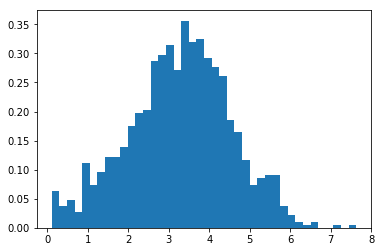

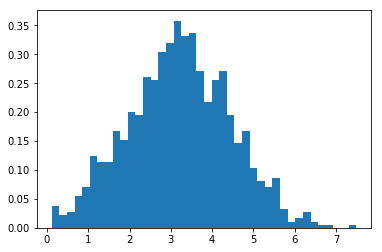

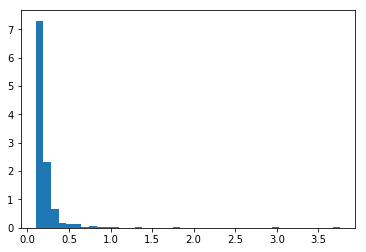

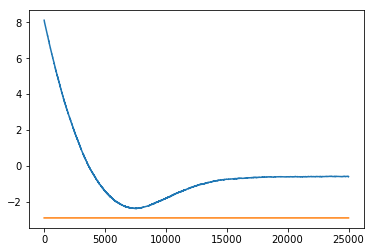

In [179]:
def helium_wavefunction(X):
    r1, r2, alpha = X[0], X[1], X[2]
    return np.exp(- alpha * (r1 + r2))

def helium_local_energy(X):
    r1, r2, alpha = X[0], X[1], X[2]
    return alpha**2 - (27 / 8) * alpha

vmc = VMC(
    wavefunction=helium_wavefunction,
    hamiltonian=helium_local_energy,
    n_parameters=3,
    n_steps=25000,
    n_walkers=1000,
    step_size=0.05,
    proposal_distribution=np.random.normal,
    loc=0.0,
    scale=0.15,
    size=[3, 1000]
)

vmc.run()
print(vmc.acceptance_rate)
plt.hist(vmc.current[0], bins=40, normed=True)
plt.show()
plt.hist(vmc.current[1], bins=40, normed=True)
plt.show()
plt.hist(vmc.current[2], bins=40, normed=True)
plt.show()
plt.plot(vmc.expectation_values)
plt.plot(np.ones(vmc.n_steps) * -2.904)
plt.show()   

0.936


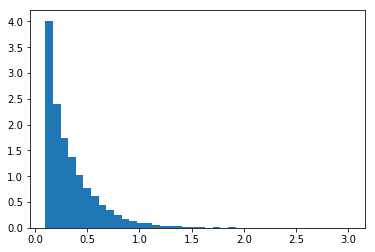

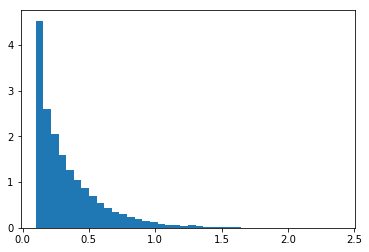

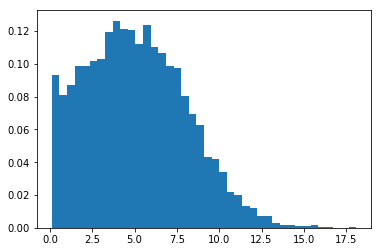

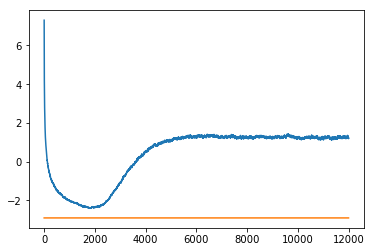

In [180]:
def helium_wavefunction(X):
    r1, r2, alpha = X[0], X[1], X[2]
    r12 = np.abs(r1 - r2)
    return np.exp(- 2 * r1 - 2 * r2 + r12 / (2 * (1 + alpha * r12)))

def helium_local_energy(X):
    r1, r2, alpha = X[0], X[1], X[2]
    
    r12 = np.abs(r1 - r2)
    factor = 1 + alpha * r12
    
    E = -4
    E += alpha / factor
    E += alpha / factor**2
    E += alpha / factor**3
    E -= 1 / (4 * factor**4)
    
    return E
    

vmc = VMC(
    wavefunction=helium_wavefunction,
    hamiltonian=helium_local_energy,
    n_parameters=3,
    n_steps=12000,
    n_walkers=10000,
    step_size=0.2,
    proposal_distribution=np.random.normal,
    loc=0.0,
    scale=0.15,
    size=[3, 10000]
)

vmc.run()
print(vmc.acceptance_rate)
plt.hist(vmc.current[0], bins=40, normed=True)
plt.show()
plt.hist(vmc.current[1], bins=40, normed=True)
plt.show()
plt.hist(vmc.current[2], bins=40, normed=True)
plt.show()
plt.plot(vmc.expectation_values)
plt.plot(np.ones(vmc.n_steps) * -2.904)
plt.show()   